In [35]:
import numpy as np
import pandas as pd
import time
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import precision_recall_fscore_support, make_scorer, recall_score, f1_score, confusion_matrix, precision_score, balanced_accuracy_score
from sklearn.metrics import fbeta_score, classification_report


from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from libs.print_cm import print_cm
from libs.loader import load_malicious
         

from sklearn.model_selection import learning_curve, validation_curve

In [5]:
# df = pd.read_csv("data/malicious_01.csv")
# Xdf = df.drop(columns=["INCIDENT_ID","DATE", "MALICIOUS_OFFENSE"])
# y_mal = df["MALICIOUS_OFFENSE"]
# Xdf['X_12'] = np.nan_to_num(Xdf['X_12'])
# _X, _y = Xdf.values, y_mal.values

# minMaxNorm = MinMaxScaler()
# X = minMaxNorm.fit_transform(_X)
# # pd.DataFrame(X)

# labelEncoder = LabelEncoder()
# y_pre = labelEncoder.fit_transform(_y)
# y = 1 - y_pre
# pd.DataFrame({'y':y,'pre':y_pre})
X,y = load_malicious()


In [41]:
adaboost = AdaBoostClassifier()

# scorer = make_scorer(precision_score, pos_label=0 )
scorer = make_scorer(recall_score)
# scorer = make_scorer(recall_score,average='weighted')
# scorer = make_scorer(f1_score, average='weighted' )
# scorer = make_scorer(f1_score, pos_label=1)


cv_target = cross_validate(adaboost, X, y, cv=3, scoring=scorer)
cv_target

{'fit_time': array([0.31454515, 0.28129721, 0.29671335]),
 'score_time': array([0.02675986, 0.02647495, 0.03313994]),
 'test_score': array([0.92134831, 0.86891386, 0.95131086])}

In [7]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, stratify=y,random_state=0)
adaboost.fit(X_train,y_train)
pass

In [9]:
def stats_pac( label, estimator, X_data, y_data ):
    predicted = estimator.predict(X_data)
    print ('****** %s ******' % label)
    cm = confusion_matrix(y_data, predicted)
    print ('Confusion matrix')
    print_cm(cm, labels=['0','1'])
    
    print ('Recall - label 0: %0.4f'% recall_score(y_data, predicted, pos_label=0))
    print ('Recall - label 1: %0.4f'% recall_score(y_data, predicted))

    print ('Precsion - label 0: %0.4f'% precision_score(y_data, predicted, pos_label=0))
    print ('Precsion - label 1: %0.4f'% precision_score(y_data, predicted))
    
    sample_wt = [ 3 if i == 1 else 1 for i in predicted]
    print ('F1 Score macro: %0.4f'% f1_score(y_data, predicted, average='macro', sample_weight=sample_wt ))
    print ('F1 Score - label 0 : %0.4f'% f1_score(y_data, predicted, pos_label=0 ))
    print ('F1 Score - label 1 : %0.4f'% f1_score(y_data, predicted, pos_label=1 ))
    print ('F1 Score - weighted avg : %0.4f'% f1_score(y_data, predicted, average='weighted' ))
    print ('F1 Beta - b=2 weighted avg : %0.4f'% fbeta_score(y_data,predicted, average='weighted', beta=2))
    
    print (classification_report(y_data, predicted, labels=[1,0]))


stats_pac('SVM plain - Train', adaboost, X_train, y_train)
stats_pac('SVM plain - Validation', adaboost, X_test, y_test)

****** SVM plain - Train ******
Confusion matrix
              0     1 
        0 13661    11 
        1    35   606 
Recall - label 0: 0.9992
Recall - label 1: 0.9454
Precsion - label 0: 0.9974
Precsion - label 1: 0.9822
F1 Score macro: 0.9896
F1 Score - label 0 : 0.9983
F1 Score - label 1 : 0.9634
F1 Score - weighted avg : 0.9968
F1 Beta - b=2 weighted avg : 0.9968
              precision    recall  f1-score   support

           1       0.98      0.95      0.96       641
           0       1.00      1.00      1.00     13672

    accuracy                           1.00     14313
   macro avg       0.99      0.97      0.98     14313
weighted avg       1.00      1.00      1.00     14313

****** SVM plain - Validation ******
Confusion matrix
              0     1 
        0  3408    11 
        1     9   151 
Recall - label 0: 0.9968
Recall - label 1: 0.9437
Precsion - label 0: 0.9974
Precsion - label 1: 0.9321
F1 Score macro: 0.9748
F1 Score - label 0 : 0.9971
F1 Score - label 1 : 0.93

## Hypers


In [19]:

adaboost1 = AdaBoostClassifier(random_state=0)
strat_cv = StratifiedKFold(3, shuffle=True,  random_state=0)
range_list1  = np.linspace(1, 175, 25).astype('int32')
range_list1


array([  1,   8,  15,  22,  30,  37,  44,  51,  59,  66,  73,  80,  88,
        95, 102, 109, 117, 124, 131, 138, 146, 153, 160, 167, 175],
      dtype=int32)

In [20]:
ada_train_scores1, ada_test_scores1 = validation_curve(
    adaboost1, X, y, param_name="n_estimators", param_range=range_list1,
    scoring=scorer, cv=strat_cv, n_jobs=-1)
print("done")

done


In [21]:
train_scores_mean1 = np.mean(ada_train_scores1, axis=1)
test_scores_mean1 = np.mean(ada_test_scores1, axis=1)
# print (range_list.shape,train_scores_mean.shape,test_scores_mean.shape)
df_1 = pd.DataFrame({'x':range_list1,'train':train_scores_mean1,'test':test_scores_mean1} )
df_1

,x,train,test
0,1,0.000000,0.000000
1,8,0.287765,0.304619
2,15,0.561174,0.549313
3,22,0.697253,0.662921
4,30,0.792759,0.782772
5,37,0.887016,0.880150
6,44,0.922597,0.920100
7,51,0.935705,0.923845
8,59,0.950687,0.943820
9,66,0.954432,0.942572


Text(0.5, 1.0, 'AdaBoost Validation curve:\nAdaboost Weak Learners')

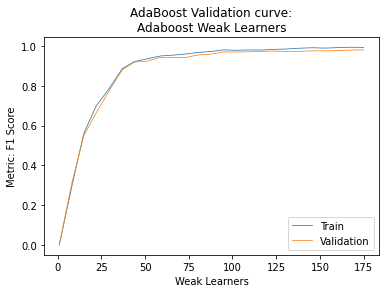

In [22]:
axs = plt.gca()
axs.plot(df_1['x'], df_1['train'], label='Train', linewidth=0.75)
axs.plot(df_1['x'], df_1['test'], label='Validation', linewidth=0.75)
axs.legend(); axs.set_ylabel("Metric: F1 Score"); axs.set_xlabel("Weak Learners")
# axs.set_xscale('log')
axs.set_title('AdaBoost Validation curve:\nAdaboost Weak Learners')

In [ ]:
?AdaBoostClassifier

In [59]:

adaboost2 = AdaBoostClassifier(random_state=0)
strat_cv = StratifiedKFold(3, shuffle=True,  random_state=0)
range_list2  = np.linspace(0.1, 4.5, 30)
range_list2


array([0.1       , 0.25172414, 0.40344828, 0.55517241, 0.70689655,
       0.85862069, 1.01034483, 1.16206897, 1.3137931 , 1.46551724,
       1.61724138, 1.76896552, 1.92068966, 2.07241379, 2.22413793,
       2.37586207, 2.52758621, 2.67931034, 2.83103448, 2.98275862,
       3.13448276, 3.2862069 , 3.43793103, 3.58965517, 3.74137931,
       3.89310345, 4.04482759, 4.19655172, 4.34827586, 4.5       ])

In [60]:
ada_train_scores2, ada_test_scores2 = validation_curve(
    adaboost1, X, y, param_name="learning_rate", param_range=range_list2,
    scoring=scorer, cv=strat_cv, n_jobs=-1)
print("done")

done


In [61]:
train_scores_mean2 = np.mean(ada_train_scores2, axis=1)
test_scores_mean2 = np.mean(ada_test_scores2, axis=1)
# print (range_list.shape,train_scores_mean.shape,test_scores_mean.shape)
df_2 = pd.DataFrame({'x':range_list2,'train':train_scores_mean2,'test':test_scores_mean2} )
df_2

,x,train,test
0,0.100000,0.146067,0.144819
1,0.251724,0.406991,0.403246
2,0.403448,0.501248,0.488140
3,0.555172,0.665418,0.637953
4,0.706897,0.828964,0.810237
5,0.858621,0.913233,0.881398
6,1.010345,0.940699,0.932584
7,1.162069,0.955680,0.943820
8,1.313793,0.958177,0.951311
9,1.465517,0.975655,0.966292


Text(0.5, 1.0, 'AdaBoost Validation curve:\nAdaboost Learning Rate')

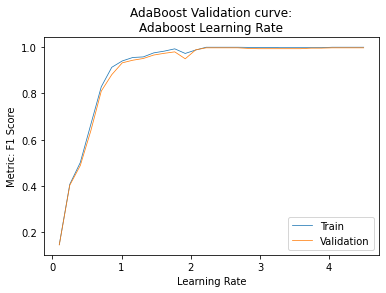

In [62]:
axs = plt.gca()
axs.plot(df_2['x'], df_2['train'], label='Train', linewidth=0.75)
axs.plot(df_2['x'], df_2['test'], label='Validation', linewidth=0.75)
axs.legend(); axs.set_ylabel("Metric: F1 Score"); axs.set_xlabel("Learning Rate")
# axs.set_xscale('log')
axs.set_title('AdaBoost Validation curve:\nAdaboost Learning Rate')

In [42]:
scorer

make_scorer(recall_score)

In [63]:

adaboost3 = AdaBoostClassifier(random_state=0)
the_srch = RandomizedSearchCV(
    adaboost3, 
    {"learning_rate": np.linspace(1, 5, 10), "n_estimators":np.linspace(25,70,10).astype('int32')},
    scoring=scorer,
    return_train_score=False,
    cv=strat_cv,
    n_iter=75,
    random_state=0,
    n_jobs=-1
)
print(the_srch)
tic = time.perf_counter()
the_srch.fit(X,y)
toc = time.perf_counter()
print(f"Total time : {toc-tic:0.4f} seconds")

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
                   estimator=AdaBoostClassifier(random_state=0), n_iter=75,
                   n_jobs=-1,
                   param_distributions={'learning_rate': array([1.        , 1.44444444, 1.88888889, 2.33333333, 2.77777778,
       3.22222222, 3.66666667, 4.11111111, 4.55555556, 5.        ]),
                                        'n_estimators': array([25, 30, 35, 40, 45, 50, 55, 60, 65, 70], dtype=int32)},
                   random_state=0, scoring=make_scorer(recall_score))
Total time : 13.2907 seconds


In [64]:
less_5 = pd.DataFrame(the_srch.cv_results_)['rank_test_score'] <= 5

filtered_series = pd.DataFrame(the_srch.cv_results_)[less_5].filter(['params','rank_test_score','mean_test_score'])
sorted_series =  (filtered_series.sort_values(by=['rank_test_score']))
out_rows = [r for r in sorted_series.values]
# type(pd.DataFrame(mlp_rand.cv_results_)[less_5]['params'])
for r in out_rows:
    print( f"rank:{r[1]} -- params{r[0]} score:{r[2]}")

pd.DataFrame(the_srch.cv_results_)[less_5]

rank:1 -- params{'n_estimators': 50, 'learning_rate': 4.111111111111111} score:0.9975031210986267
rank:1 -- params{'n_estimators': 70, 'learning_rate': 4.555555555555555} score:0.9975031210986267
rank:1 -- params{'n_estimators': 50, 'learning_rate': 4.555555555555555} score:0.9975031210986267
rank:1 -- params{'n_estimators': 70, 'learning_rate': 4.111111111111111} score:0.9975031210986267
rank:1 -- params{'n_estimators': 30, 'learning_rate': 2.333333333333333} score:0.9975031210986267
rank:1 -- params{'n_estimators': 50, 'learning_rate': 2.333333333333333} score:0.9975031210986267
rank:1 -- params{'n_estimators': 30, 'learning_rate': 5.0} score:0.9975031210986267
rank:1 -- params{'n_estimators': 30, 'learning_rate': 2.7777777777777777} score:0.9975031210986267
rank:1 -- params{'n_estimators': 70, 'learning_rate': 5.0} score:0.9975031210986267
rank:1 -- params{'n_estimators': 50, 'learning_rate': 2.7777777777777777} score:0.9975031210986267
rank:1 -- params{'n_estimators': 30, 'learning

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
4,0.265661,0.000944,0.053330,0.001034,50,4.111111,"{'n_estimators': 50, 'learning_rate': 4.111111...",0.992509,1.0,1.0,0.997503,0.003531,1
5,0.216342,0.002177,0.042046,0.000769,40,5.0,"{'n_estimators': 40, 'learning_rate': 5.0}",0.992509,1.0,1.0,0.997503,0.003531,1
7,0.248819,0.007354,0.050503,0.006009,40,4.111111,"{'n_estimators': 40, 'learning_rate': 4.111111...",0.992509,1.0,1.0,0.997503,0.003531,1
9,0.290230,0.011122,0.064283,0.003422,50,5.0,"{'n_estimators': 50, 'learning_rate': 5.0}",0.992509,1.0,1.0,0.997503,0.003531,1
18,0.245761,0.002265,0.047319,0.003454,40,2.333333,"{'n_estimators': 40, 'learning_rate': 2.333333...",0.992509,1.0,1.0,0.997503,0.003531,1
20,0.271097,0.001457,0.045440,0.001096,40,2.777778,"{'n_estimators': 40, 'learning_rate': 2.777777...",0.992509,1.0,1.0,0.997503,0.003531,1
23,0.176682,0.004849,0.037692,0.001877,30,4.111111,"{'n_estimators': 30, 'learning_rate': 4.111111...",0.992509,1.0,1.0,0.997503,0.003531,1
24,0.319907,0.002385,0.056271,0.002281,50,2.777778,"{'n_estimators': 50, 'learning_rate': 2.777777...",0.992509,1.0,1.0,0.997503,0.003531,1
27,0.373581,0.006536,0.078732,0.003859,70,5.0,"{'n_estimators': 70, 'learning_rate': 5.0}",0.992509,1.0,1.0,0.997503,0.003531,1
43,0.228282,0.002691,0.041436,0.005091,30,2.777778,"{'n_estimators': 30, 'learning_rate': 2.777777...",0.992509,1.0,1.0,0.997503,0.003531,1
